# XGBoost

**XGBoost (Extreme Gradient Boostin)** is a Gradient Boosting Decision Trees.<br> 
It implements [gradient boosting](https://en.wikipedia.org/wiki/Gradient_boosting) using decision trees and is widely used for both **classification** and **regrssion** tasks.

Its core idea is **building trees sequentially**, where each new tree **learns** from past mistakes using **gradients** of the loss function. This state-of-the-art algorithm scales well to large datasets, handles missing values natively, but categorical features need manual encoding before using it. Also, **XGBoost** is **level-wise**, this means that it grows leaves at the same depth before moving deeper.

Regarding **feature sampling**, XGBoost uses **all features** when searching for the best split at each node. This can lear to more accurate trees, but potentially more correlated ones (i.e., you can use the parameter `colsample_bytree` to enable feature subsampling - this helps introducing randomness).The **split criterion** is based on the **gain on gradients & hessians**. Different from Random Forest, the **row sampling** in XGBoost is **optional** since it focus on **hard examples**.

**Installing XGBoost:**<br>
You can install the package as follows:
```bash
$ pip install xgboost
```

**Use case:**<br>
I built a sample implementation of the XGBoost model to demostrates its functionality.

## Use Case / Implementation

The **goal** is to **predict** the **califonia house prices**. Therefore, we use the **XGBosstRegressor**.

**[Note]**: Just to clarify, my goal is to demonstrate the XGBoost implementation - not necessarily to solve the problem in the most optimal way.

In [3]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import r2_score, root_mean_squared_error, mean_squared_error

In [4]:
# Pulling data
california_ds = fetch_california_housing(as_frame=True)

X = california_ds["data"]
y = california_ds["target"]

X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


### Checking on Data / EDA

In [6]:
# Check data
X.describe().round(3)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000,20640.000,20640.000,20640.000,20640.000,20640.000,20640.000,20640.000
mean,3.871,28.639,5.429,1.097,1425.477,3.071,35.632,-119.570
std,1.900,12.586,2.474,0.474,1132.462,10.386,2.136,2.004
min,0.500,1.000,0.846,0.333,3.000,0.692,32.540,-124.350
25%,2.563,18.000,4.441,1.006,787.000,2.430,33.930,-121.800
50%,3.535,29.000,5.229,1.049,1166.000,2.818,34.260,-118.490
75%,4.743,37.000,6.052,1.100,1725.000,3.282,37.710,-118.010
max,15.000,52.000,141.909,34.067,35682.000,1243.333,41.950,-114.310


In [7]:
# Missing values?
missing_values = X.isnull().sum()
display(missing_values)

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64

In [8]:
# Check correlation between target and other features

tmp_X = X.copy()
tmp_X["target"] = y
correlations = tmp_X.corr().loc[:,["target"]]

correlations.sort_values("target", ascending=False).iloc[1:,:]

,target
MedInc,0.688075
AveRooms,0.151948
HouseAge,0.105623
AveOccup,-0.023737
Population,-0.024650
Longitude,-0.045967
AveBedrms,-0.046701
Latitude,-0.144160


**Remarks**
- This was just an example of steps in EDA. I'm not going to continue checking on the data since I'm focusing on the implementation of XGBoost model. Thus, I just exemplified the EDA phase - before building the model.

#### Split dataset

I'm going to split the dataset into training, validation, and test sets.

In [11]:
# Test set
X_ds, X_test, y_ds, y_test = train_test_split(
    X,y, test_size=0.2, random_state=42)

# Training and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_ds, y_ds, test_size=0.1, random_state=42 
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Training set: (14860, 8)
Validation set: (1652, 8)
Test set: (4128, 8)


### Building model

Building XGBoost model

Evaluation (Validation):
 - MSE: 0.249
 - RMSE: 0.499
 - R2: 0.822


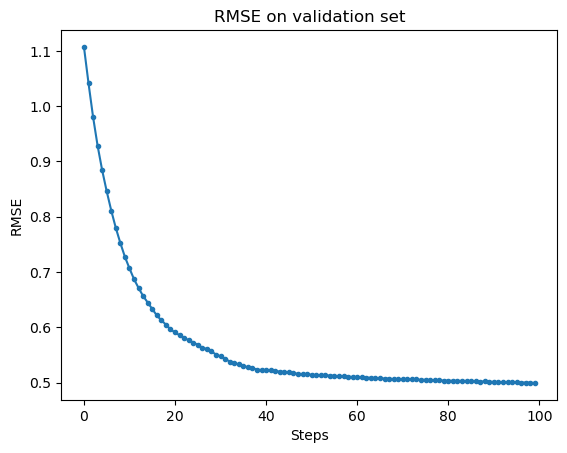

In [13]:
model = xgb.XGBRegressor(learning_rate=0.1, eval_metric="rmse")
model.fit(X_train, 
          y_train, 
          eval_set=[(X_val, y_val)], 
          verbose=0,)

predictions = model.predict(X_val)

# Evaluation
mse = mean_squared_error(y_val, predictions)
rmse = root_mean_squared_error(y_val, predictions)
r2 = r2_score(y_val, predictions)

print("Evaluation (Validation):")
print(f" - MSE: {mse:.3f}")
print(f" - RMSE: {rmse:.3f}")
print(f" - R2: {r2:.3f}")

# Plot validation RMSE
m_eval = model.evals_result()["validation_0"]["rmse"]
plt.plot(list(range(len(m_eval))), m_eval, marker=".")
plt.title("RMSE on validation set")
plt.ylabel("RMSE")
plt.xlabel("Steps")
plt.show()

In [14]:
# Predict: Test set
test_preds = model.predict(X_test)

# Metrics: test
mse = mean_squared_error(y_test, test_preds)
rmse = root_mean_squared_error(y_test, test_preds)
r2 = r2_score(y_test, test_preds)

print("Evaluation (Test):")
print(f" - MSE: {mse:.3f}")
print(f" - RMSE: {rmse:.3f}")
print(f" - R2: {r2:.3f}")

Evaluation (Test):
 - MSE: 0.228
 - RMSE: 0.477
 - R2: 0.826


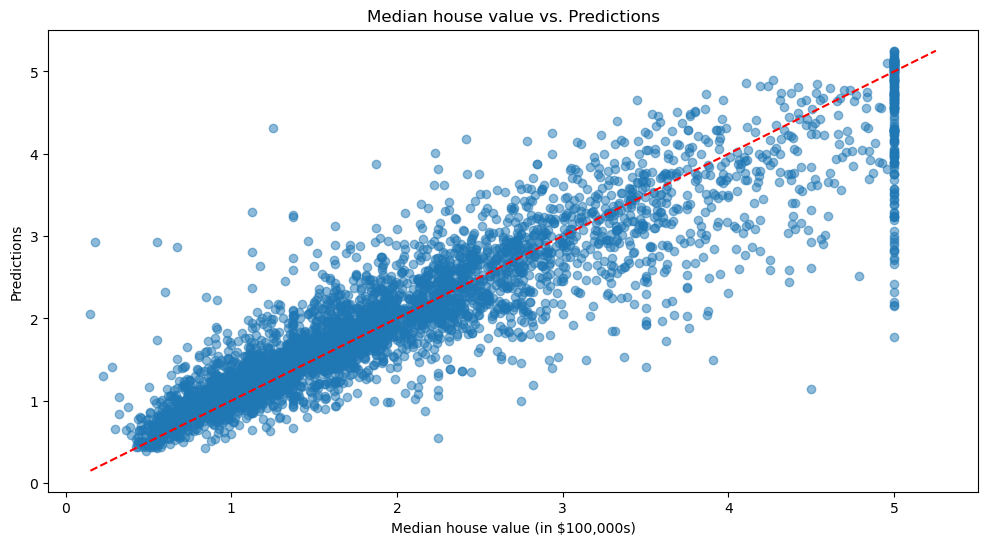

In [15]:
# Plot median hous values vs. Predictions (Test set)

# For the diagonal red line
min_val = min(y_test.min(), test_preds.min())
max_val = max(y_test.max(), test_preds.max())

fig = plt.figure(figsize=(12,6))
ax = plt.scatter(x=y_test, y=test_preds, alpha=.5)
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.title("Median house value vs. Predictions")
plt.xlabel("Median house value (in $100,000s)")
plt.ylabel("Predictions")
plt.show()

___